# Example Interrupted Time Series (ITS) with `pymc` models

This notebook shows an example of using interrupted time series, where we do not have untreated control units of a similar nature to the treated unit and we just have a single time series of observations and the predictor variables are simply time and month.

In [1]:
import arviz as az
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Interrupted Time Series (ITS) Example

Load data

In [3]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [4]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


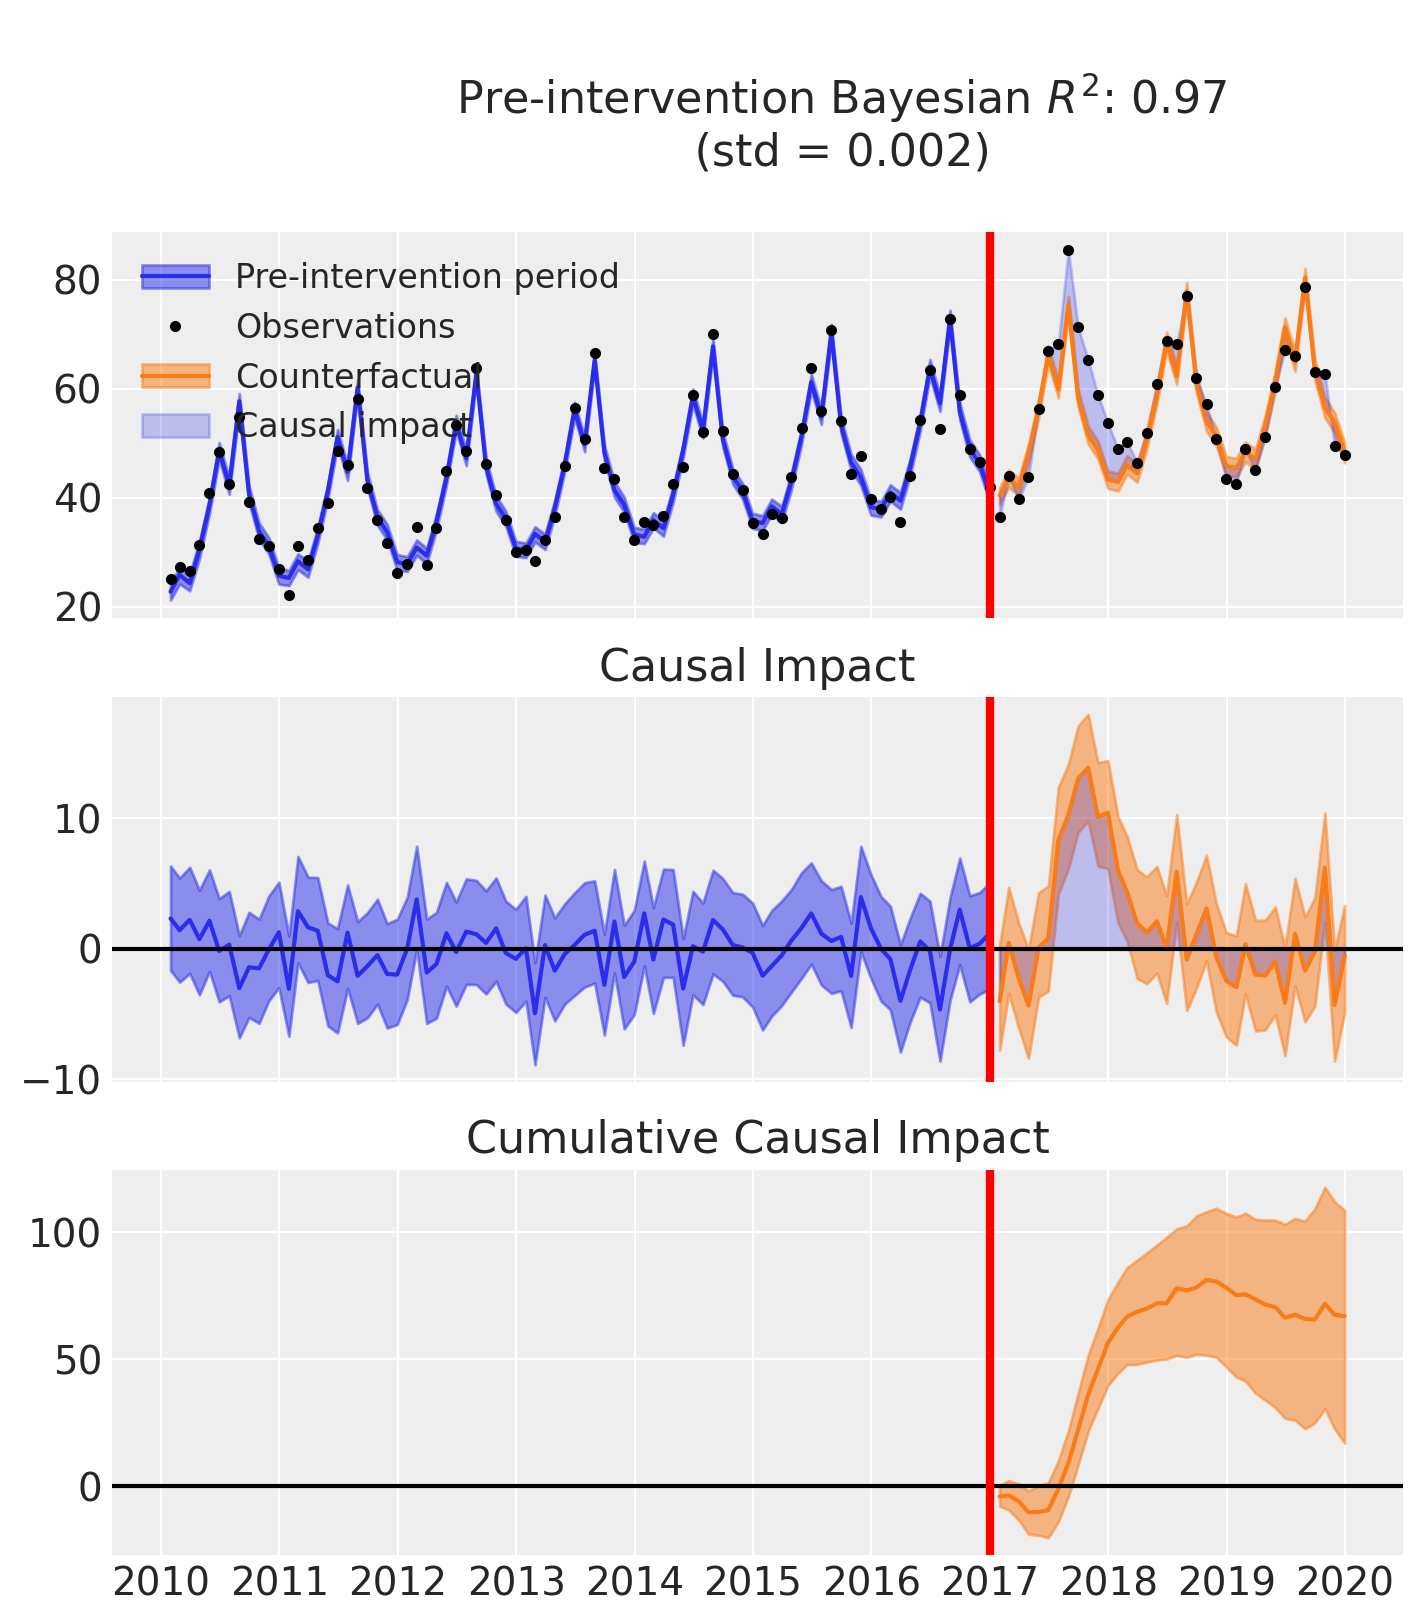

In [5]:
fig, ax = result.plot()

In [6]:
result.summary()

==================================Pre-Post Fit==================================
Formula: y ~ 1 + t + C(month)
Model coefficients:
    Intercept       23, 94% HDI [21, 24]
    C(month)[T.2]   2.9, 94% HDI [0.88, 4.8]
    C(month)[T.3]   1.2, 94% HDI [-0.82, 3.1]
    C(month)[T.4]   7.2, 94% HDI [5.2, 9.1]
    C(month)[T.5]   15, 94% HDI [13, 17]
    C(month)[T.6]   25, 94% HDI [23, 27]
    C(month)[T.7]   18, 94% HDI [16, 20]
    C(month)[T.8]   33, 94% HDI [32, 35]
    C(month)[T.9]   16, 94% HDI [14, 18]
    C(month)[T.10]  9.2, 94% HDI [7.3, 11]
    C(month)[T.11]  6.3, 94% HDI [4.4, 8.2]
    C(month)[T.12]  0.61, 94% HDI [-1.3, 2.5]
    t               0.21, 94% HDI [0.19, 0.23]
    sigma           2, 94% HDI [1.7, 2.3]


As well as the model coefficients, we might be interested in the average causal impact and average cumulative causal impact.

:::{note}
Better output for the summary statistics are in progress!
:::

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [7]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[unit_0],1.859,0.671,0.472,3.017,0.013,0.009,2724.0,3334.0,1.0


:::{warning}
Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [8]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[unit_0],66.907,24.168,16.989,108.609,0.463,0.323,2724.0,3334.0,1.0


## Structural Time Series (BSTS)
The following example will show how to use BSTS models, where we do not have untreated control units, using basis exansion functions such a fourier or changingpoints to estimate the effect of the intervention.

### Basis Expansion models.

/opt/anaconda3/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
/opt/anaconda3/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
/opt/anaconda3/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_beta, delta, beta, sigma]


Output()

Sampling 4 chains for 900 tune and 300 draw iterations (3_600 + 1_200 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, delta, fourier_beta, sigma, y_hat]
Sampling: [y_hat]


Output()

Sampling: [y_hat]


Output()

Sampling: [y_hat]


Output()

Sampling: [y_hat]


Output()

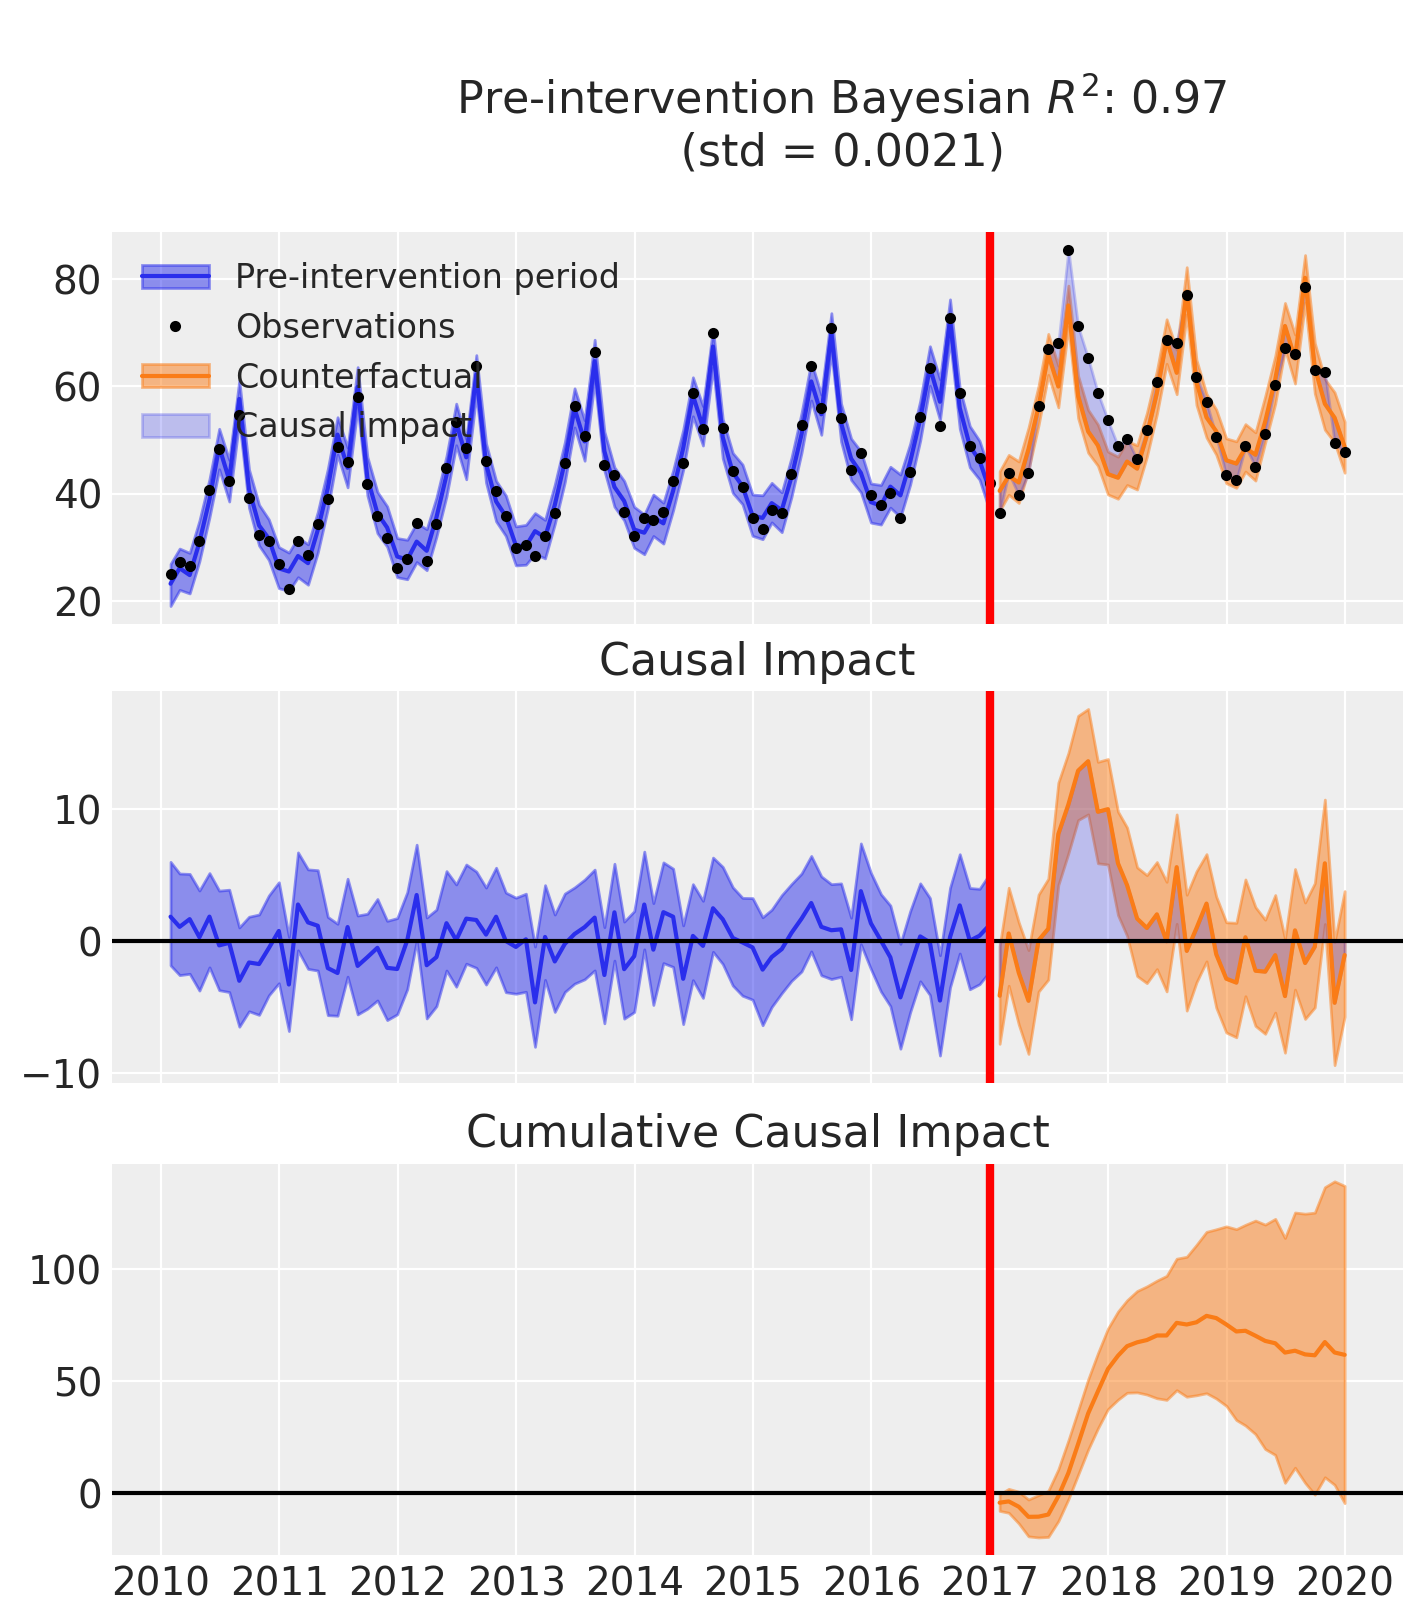

In [9]:
bsts_model = cp.pymc_models.BayesianBasisExpansionTimeSeries(
    n_order=10,
    n_changepoints_trend=4,
    prior_sigma=0.5,
    sample_kwargs={
        "chains": 4,
        "draws": 300,
        "tune": 900,
        "progressbar": True,
        "random_seed": 42,
        "target_accept": 0.75,
    },
)

bsts_result = cp.StructuralTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1",  # Exogenous regressors are optional
    model=bsts_model,
)

fig, ax = bsts_result.plot()

### State Space models

In [10]:
sampler_kwargs = {
    "nuts_sampler": "nutpie",
    "chains": 6,
    "draws": 400,
    "tune": 600,
    "nuts_sampler_kwargs": {"backend": "jax", "gradient_backend": "jax"},
    "target_accept": 0.93,
}

ssts = cp.pymc_models.StateSpaceTimeSeries(
    level_order=3,
    seasonal_length=12,
    sample_kwargs=sampler_kwargs,
    mode="JAX",
)

ssts_result = cp.StructuralTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1",  # Exogenous regressors are optional
    model=ssts,
    sample_kwargs=sampler_kwargs,
)

                              Model Requirements                              
                                                                              
  Variable        Shape      Constraints                          Dimensions  
 ──────────────────────────────────────────────────────────────────────────── 
  initial_trend   (3,)                                      ('trend_state',)  
  sigma_trend     (3,)       Positive                       ('trend_shock',)  
  freq            (11,)                                      ('freq_state',)  
  sigma_freq      ()         Positive                                   None  
  P0              (15, 15)   Positive semi-definite   ('state', 'state_aux')  
                                                                              
 These parameters should be assigned priors inside a PyMC model block before  
                  calling the build_statespace_graph method.                  

/opt/anaconda3/envs/CausalPy/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:92: UserWarning: No frequency was specific on the data's DateTimeIndex.
  warnings.warn(NO_FREQ_INFO_WARNING)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.31,15
,1000,0,0.32,15
,1000,1,0.33,15
,1000,0,0.33,15
,1000,0,0.33,15
,1000,0,0.31,15


Sampling: [obs]


Output()

/opt/anaconda3/envs/CausalPy/lib/python3.13/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x32CF1CD60>), RNG(<Generator(PCG64) at 0x32CF1DFC0>), RNG(<Generator(PCG64) at 0x32CF1D7E0>), RNG(<Generator(PCG64) at 0x32D2B98C0>), RNG(<Generator(PCG64) at 0x32D2B9620>), RNG(<Generator(PCG64) at 0x3771EE960>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

/opt/anaconda3/envs/CausalPy/lib/python3.13/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x37AD2BA00>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


Output()

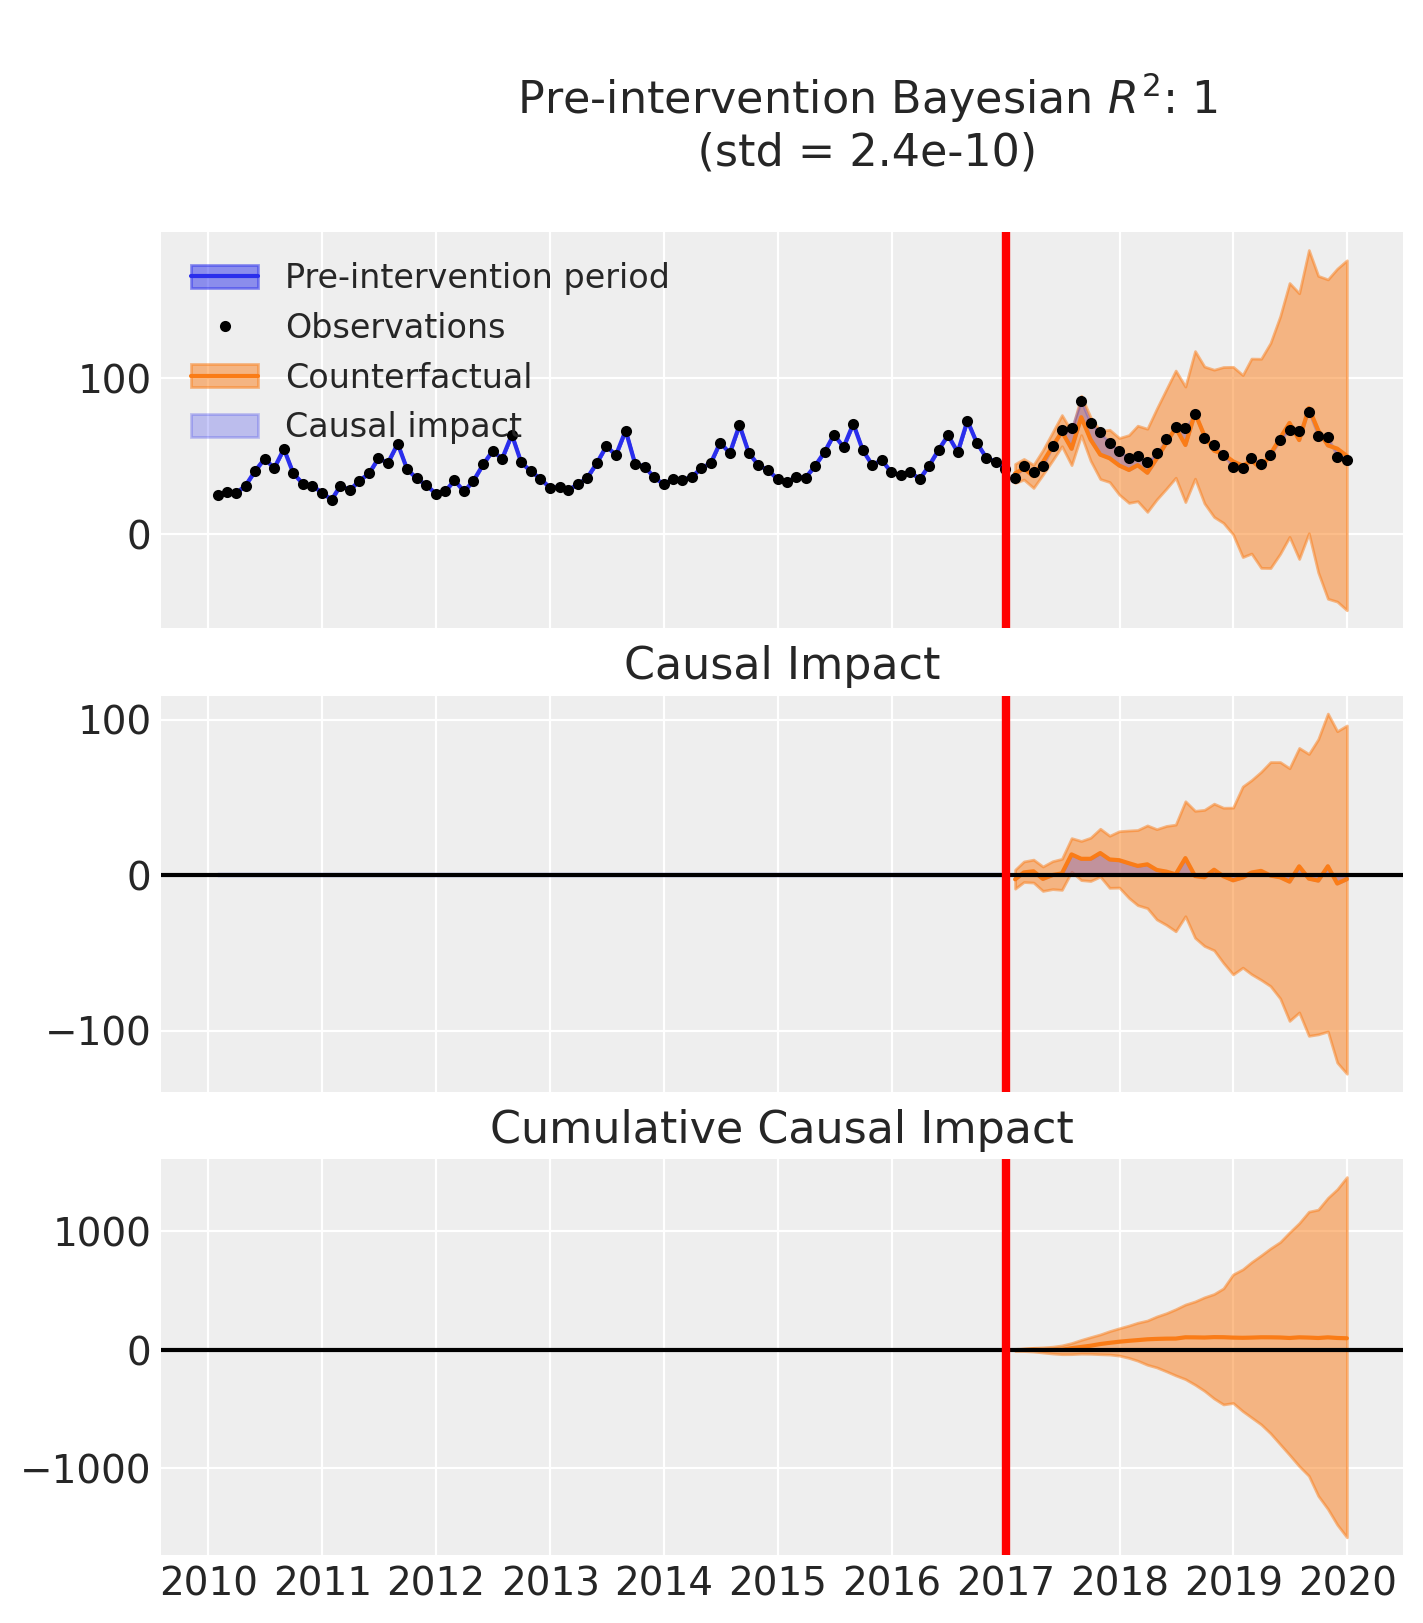

In [12]:
fig, ax = ssts_result.plot()